In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader

In [2]:
transform=transforms.Compose([transforms.RandomRotation(30),
                              transforms.RandomResizedCrop(224),
                              transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [3]:
train=datasets.ImageFolder("Data/train/",transform=transform)

In [4]:
valid=datasets.ImageFolder("Data/valid/",transform=transform)

In [5]:
trainload=DataLoader(train,shuffle=True,batch_size=32)
validload=DataLoader(valid,shuffle=True,batch_size=16)

In [6]:
image,label=next(iter(trainload))
image.size()

torch.Size([32, 3, 224, 224])

tensor(40)


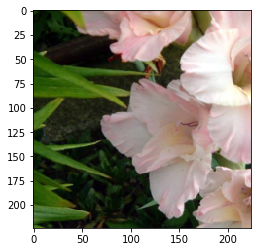

In [7]:
def imshow(image,norm=True,title=None,ax=None):
    image=image.numpy().transpose((1,2,0))
    if norm:
        mean=np.array([0.5,0.5,0.5])
        std=np.array([0.5,0.5,0.5])
        image=image*std+mean
    plt.imshow(image)
    return 0
imshow(image[4])
print(label[4])
        

In [8]:
model_name="resnet"
if model_name in ["resnet","resnet18"]:
    model=models.resnet18(pretrained=True)
    inpt=model.fc.in_features
    print(model.fc)
elif model_name in ["vgg","vgg16"]:
    model=models.vgg16(pretrained=True)
    inpt=model.classifier[0].in_features
    print(model.classifier)
else:
    print("unknow architecture ")

Linear(in_features=512, out_features=1000, bias=True)


In [9]:
for param in model.parameters():
    param.requires_grad=False

In [10]:
# hidden_units=512
# hidden_layers=[]
# if hidden_units>1000:
#     while(hidden_units> 102):
#         hidden_layers.append(hidden_units)
#         hidden_units=hidden_units//4
# else:
#     while(hidden_units>102):
#         hidden_layers.append(hidden_units)
#         hidden_units=hidden_units//2
# print(hidden_layers)
        
        


In [11]:
from torch import nn
classifier=nn.Sequential()
classifier.add_module("output",nn.Linear(inpt,102))


In [12]:
from torch import optim
lr=0.01
if model_name in ["resnet","resnet18"]:
    model.fc=classifier
    optimizer=optim.Adam(model.fc.parameters(),lr=lr)
elif model_name in ["vgg","vgg16"]:
    model.classifier=classifier
    optimizer=optim.Adam(model.classifier.parameters(),lr=lr)
loss=nn.CrossEntropyLoss()

In [13]:
datasize={"train":len(train),"valid":len(valid)
}

In [14]:
import time
import copy
since=time.time()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs=2
best_arch=copy.deepcopy(model.state_dict())
best_acc=0.0
model.to(device)
step=0
temp=0.0
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1,epochs))
    print("*-*"*10)
        
    for phase in ["train","valid"]:
        if phase=="train":
            model.train()
            dataload=trainload
        else:
            model.eval()
            dataload=validload
        run_loss=0.0
        run_correct=0
        for image,label in dataload:
            image=image.to(device)
            label=label.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=="train"):
                output=model(image)
                preds=torch.max(output,1)[1]
                l=loss(output,label)
                if phase=="train":
                    l.backward()
                    optimizer.step()
            step+=1
            temp+=l.item()
            run_loss+=l.item()*image.size(0)
            run_correct+=torch.sum(preds==label.data)
            if step%32==0:
                print("Loss : {:.4f} ".format(temp/32))
                temp=0
                
        epoch_loss=run_loss/datasize[phase]
        epoch_acc=run_correct.double()/datasize[phase]

        print("{} :  ,loss : {:.4f}  ,Acc :{:.4f}".format(phase,epoch_loss,epoch_acc))
        if phase=="valid" and epoch_acc>best_acc:
            best_acc=epoch_acc
            best_arch=copy.deepcopy(model.state_dict())
t=time.time()-since
print("time taken {:.0f}m {:.0f}s".format(t//60,t%60))
print("best accuracy {:.4f}".format(best_acc))

Epoch 1/2
*-**-**-**-**-**-**-**-**-**-*
Loss : 6.4480 
Loss : 2.8093 
Loss : 1.8548 
Loss : 1.6069 
Loss : 1.6215 
Loss : 1.5265 
train :  ,loss : 2.5592  ,Acc :0.5308
Loss : 1.2155 
Loss : 1.2588 
valid :  ,loss : 1.2217  ,Acc :0.7200
Epoch 2/2
*-**-**-**-**-**-**-**-**-**-*
Loss : 1.2152 
Loss : 1.2192 
Loss : 1.2850 
Loss : 1.4365 
Loss : 1.2046 
Loss : 1.3005 
train :  ,loss : 1.2882  ,Acc :0.7114
Loss : 1.1739 
Loss : 1.0118 
valid :  ,loss : 1.0177  ,Acc :0.7738
time taken 6m 7s
best accuracy 0.7738


In [15]:
label

tensor([53, 96], device='cuda:0')